In [ ]:
!pip install -U deepctr-torch -q
!pip install tensorboard -q
!pip install faiss-cpu -q

In [ ]:
import glob
import json
import os
import random
from collections import namedtuple

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepctr_torch.inputs import DenseFeat, SparseFeat, get_feature_names
from deepctr_torch.models import DIFM
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

data_df = pd.read_csv('dataset/data.csv')

In [2]:
data_df

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2025-04-10 03:36:16.589,6471,2115,1.00,0.000319,47732.0,{'PERSONALIZED': 'T1'},0.219124
1,next,2025-04-10 03:36:16.598,7652,40195,0.48,0.000338,36705.0,{'PERSONALIZED': 'C'},0.045350
2,next,2025-04-10 03:36:16.599,7652,36705,0.43,0.000408,24663.0,{'PERSONALIZED': 'C'},0.877923
3,next,2025-04-10 03:36:16.602,9615,27452,0.53,0.000330,4058.0,{'PERSONALIZED': 'T1'},0.283448
4,next,2025-04-10 03:36:16.605,7652,33591,0.22,0.000364,40195.0,{'PERSONALIZED': 'C'},0.179900
...,...,...,...,...,...,...,...,...,...
3329509,next,2025-04-09 19:15:13.521,5469,26288,0.00,0.001104,26288.0,{'PERSONALIZED': 'C'},0.196796
3329510,last,2025-04-09 19:15:13.524,5469,26288,0.00,0.000267,NaN,{'PERSONALIZED': 'C'},0.598651
3329511,next,2025-04-09 19:15:13.530,7485,22030,1.00,0.000658,44056.0,{'PERSONALIZED': 'T1'},0.863714
3329512,next,2025-04-09 19:15:13.534,7485,44056,0.01,0.000693,43082.0,{'PERSONALIZED': 'T1'},0.921825


In [57]:
positives = data_df[data_df["time"] >= 0.6].copy()

track_counts = positives.groupby("track").size()
tracks = set(track_counts
             [track_counts >= 1]
             .index.values)

data_filt_pos = positives[positives["track"].isin(tracks)]

len(data_filt_pos), len(tracks)

(872672, 49755)

In [58]:
user_counts_pos = data_filt_pos.user.value_counts().to_dict()

In [59]:
data_filt_neg = data_df[data_df["time"] <= 0.3]

In [60]:
pos_pairs = set(data_filt_pos[['user', 'track']].apply(tuple, axis=1))

data_filt_neg = data_df[data_df["time"] <= 0.3].copy()
data_filt_neg["pair"] = list(zip(data_filt_neg["user"], data_filt_neg["track"]))
data_filt_neg = data_filt_neg[~data_filt_neg["pair"].isin(pos_pairs)]

data_filt_neg = pd.concat([
    data_filt_neg[data_filt_neg["user"] == user].head(count)
    for user, count in user_counts_pos.items()
    if user in data_filt_neg["user"].values
])

data_filt_neg = data_filt_neg.drop_duplicates(['user', 'track'])

data_filt = pd.concat([data_filt_pos, data_filt_neg])

In [61]:
data_filt = pd.concat([data_filt_pos, data_filt_neg])

In [62]:
data_filt['label'] = data_filt.time.apply(lambda t: 1 if t >= 0.6 else 0)

In [63]:
data_filt

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,message,timestamp,user,track,time,latency,recommendation,experiments,rnd,pair,label
0,next,2025-04-10 03:36:16.589,6471,2115,1.00,0.000319,47732.0,{'PERSONALIZED': 'T1'},0.219124,NaN,1
5,next,2025-04-10 03:36:16.608,44,39191,1.00,0.000469,11430.0,{'PERSONALIZED': 'C'},0.763631,NaN,1
6,next,2025-04-10 03:36:16.611,9615,37737,0.90,0.000527,36218.0,{'PERSONALIZED': 'T1'},0.570915,NaN,1
8,next,2025-04-10 03:36:16.619,2678,26091,1.00,0.000423,27868.0,{'PERSONALIZED': 'T1'},0.384227,NaN,1
10,next,2025-04-10 03:36:16.625,2678,35596,0.91,0.000430,19353.0,{'PERSONALIZED': 'T1'},0.027928,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
505711,next,2025-04-10 04:02:01.981,2895,927,0.00,0.000404,8945.0,{'PERSONALIZED': 'T1'},0.962819,"(2895, 927)",0
523570,last,2025-04-10 04:02:56.600,2895,2903,0.00,0.000097,NaN,{'PERSONALIZED': 'T1'},0.564288,"(2895, 2903)",0
599692,next,2025-04-09 19:06:37.311,2895,18618,0.00,0.000399,20237.0,{'PERSONALIZED': 'T1'},0.346869,"(2895, 18618)",0
599693,next,2025-04-09 19:06:37.313,2895,20237,0.00,0.000315,27885.0,{'PERSONALIZED': 'T1'},0.441185,"(2895, 20237)",0


In [64]:
data_filt = data_filt.drop_duplicates(['user', 'track'], keep='first')

In [65]:
data_filt.user.nunique(), data_filt.track.nunique()

(10000, 50000)

In [ ]:
data_filt = data_filt[['user', 'track', 'time', 'label', 'timestamp']]
data_user_track = data_filt.copy()

In [67]:
del data_filt

In [68]:
data_user_track['timestamp'] = pd.to_datetime(data_user_track['timestamp'])
data_user_track = data_user_track.sort_values(['user', 'timestamp'])

In [69]:
data_user_track

,user,track,time,label,timestamp
3093036,0,14427,1.00,1,2025-04-09 19:06:30.580
1428484,0,37465,0.00,0,2025-04-09 19:06:30.585
600946,0,48906,1.00,1,2025-04-09 19:06:39.951
600947,0,48134,0.80,1,2025-04-09 19:06:39.954
600948,0,49761,0.64,1,2025-04-09 19:06:39.956
...,...,...,...,...,...
463553,9999,48637,0.19,0,2025-04-10 03:59:51.910
494393,9999,3637,1.00,1,2025-04-10 04:01:26.962
494395,9999,11721,0.15,0,2025-04-10 04:01:26.968
1336626,9999,31068,0.60,1,2025-04-10 04:01:57.540


In [4]:
item_factors = pd.read_json('../botify/data/tracks.json', lines=True)

In [5]:
item_factors

,artist,album,title,genre,pop,duration,track
0,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.500252,282,41164
1,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.942953,205,27544
2,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.801382,252,34702
3,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.577525,276,45907
4,Gafur,Февраль,Февраль,[1],-0.738636,160,14978
...,...,...,...,...,...,...,...
49995,Дмитрий Гревцев,Вечер под луной,Вечер под луной,[81],-0.572433,186,1794
49996,TSOY,Торнадо,Торнадо,[1],-1.171082,162,6622
49997,Тимати,Транзит,Хавчик,[10],-0.239359,185,25165
49998,Краски,Он не знает ничего (DFM Mix),Он не знает ничего (DFM Mix),[1],-0.028292,160,7780


In [80]:
df_onehot = pd.get_dummies(item_factors, columns=['artist'])

In [82]:
item_factors['genre'] = item_factors['genre'].apply(lambda x: eval(x) if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
genre_onehot = pd.DataFrame(mlb.fit_transform(item_factors['genre']), columns=[f'genre_{g}' for g in mlb.classes_])

df_final = pd.concat([df_onehot.drop(columns=['genre']), genre_onehot], axis=1)

In [83]:
df_final = df_final.sort_values('track').drop(columns=['title', 'album'])

In [84]:
bool_cols = df_final.select_dtypes(include='bool').columns
df_final[bool_cols] = df_final[bool_cols].astype('uint8')


In [85]:
scaler = StandardScaler()
df_final['duration'] = scaler.fit_transform(df_final[['duration']])

In [86]:
df_final

,pop,duration,track,artist_#2Маши,artist_#Неболира,artist_#ТВОЙТИПАЖ,artist_$uicideboy$,artist_(G)I-DLE,artist_- Ko'ngil ekanda,artist_02.14,...,genre_144,genre_145,genre_147,genre_148,genre_149,genre_150,genre_151,genre_152,genre_153,genre_154
31847,-0.680388,-1.135191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23822,0.198934,-0.568765,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30997,-0.995350,-1.374349,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30058,-0.200706,-0.367370,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30346,-0.644674,0.123533,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,-0.446757,0.136120,49995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26500,0.132489,2.716503,49996,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
42226,-0.780766,0.551499,49997,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49761,-0.817766,0.362690,49998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pca = PCA(n_components=150)
df_pca = pca.fit_transform(df_final.drop(columns='track'))

explained_variance = pca.explained_variance_ratio_.cumsum()

In [88]:
df_pca_df = pd.DataFrame(df_pca, columns=[f'pca_{i}' for i in range(df_pca.shape[1])])

In [89]:
df_pca_df = df_pca_df.reset_index()

In [90]:
df_pca_df.rename(columns={'index':'track'}, inplace=True)

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [93]:
data = data_user_track.merge(df_pca_df, on='track', how='left')

In [94]:
numeric_cols = [col for col in data.columns if col.startswith('pca_') or col in ['pop', 'duration', 'track_popularity', 'time']]
data[numeric_cols] = data[numeric_cols].fillna(0)

In [95]:
data['label'].value_counts()

label
0    556130
1    540037
Name: count, dtype: int64

In [97]:
feature_columns = [
    SparseFeat('user', vocabulary_size=data['user'].nunique(), embedding_dim=16),
    SparseFeat('track', vocabulary_size=data['track'].nunique(), embedding_dim=16),
]

In [98]:
feature_columns

[SparseFeat(name='user', vocabulary_size=10000, embedding_dim=16, use_hash=False, dtype='int32', embedding_name='user', group_name='default_group'),
 SparseFeat(name='track', vocabulary_size=50000, embedding_dim=16, use_hash=False, dtype='int32', embedding_name='track', group_name='default_group')]

In [99]:
numeric_features = [
    col for col in data.columns
    if col.startswith('pca_') or col in ['pop', 'duration', 'track_popularity']
]
feature_columns += [DenseFeat(f, dimension=1) for f in numeric_features]

In [100]:
train_input = {col: data[col].values for col in get_feature_names(feature_columns)}

train_labels = data['label'].values

In [103]:
model = DIFM(
    linear_feature_columns=feature_columns,
    dnn_feature_columns=feature_columns,
    dnn_hidden_units=[128, 64, 32],
    l2_reg_linear=1e-5,
    l2_reg_embedding=1e-5,
    l2_reg_dnn=0,
    init_std=0.0001,
    seed=42,
    dnn_dropout=0.5,
    dnn_activation='relu',
    dnn_use_bn=True,
    task='binary',
    device=device
)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['auc']
)

In [104]:
history = model.fit(
    train_input, train_labels,
    batch_size=1024, epochs=20,
    verbose=1
)

print("Модель на устройстве:", next(model.parameters()).device)

cuda
Train on 1096167 samples, validate on 0 samples, 1071 steps per epoch


1071it [00:20, 51.57it/s]


Epoch 1/20
20s - loss:  0.6767 - auc:  0.5993


1071it [00:19, 54.12it/s]


Epoch 2/20
19s - loss:  0.6357 - auc:  0.6910


1071it [00:19, 54.30it/s]


Epoch 3/20
19s - loss:  0.5788 - auc:  0.7607


1071it [00:19, 53.92it/s]


Epoch 4/20
19s - loss:  0.4829 - auc:  0.8444


1071it [00:19, 54.70it/s]


Epoch 5/20
19s - loss:  0.3822 - auc:  0.9061


1071it [00:19, 54.15it/s]


Epoch 6/20
19s - loss:  0.3039 - auc:  0.9417


1071it [00:19, 54.04it/s]


Epoch 7/20
19s - loss:  0.2480 - auc:  0.9615


1071it [00:20, 53.21it/s]


Epoch 8/20
20s - loss:  0.2084 - auc:  0.9731


1071it [00:19, 54.22it/s]


Epoch 9/20
19s - loss:  0.1793 - auc:  0.9802


1071it [00:19, 54.02it/s]


Epoch 10/20
19s - loss:  0.1555 - auc:  0.9851


1071it [00:19, 54.30it/s]


Epoch 11/20
19s - loss:  0.1371 - auc:  0.9885


1071it [00:19, 53.91it/s]


Epoch 12/20
19s - loss:  0.1224 - auc:  0.9909


1071it [00:19, 54.87it/s]


Epoch 13/20
19s - loss:  0.1096 - auc:  0.9927


1071it [00:19, 54.50it/s]


Epoch 14/20
19s - loss:  0.0996 - auc:  0.9940


1071it [00:19, 54.34it/s]


Epoch 15/20
19s - loss:  0.0914 - auc:  0.9949


1071it [00:19, 54.49it/s]


Epoch 16/20
19s - loss:  0.0826 - auc:  0.9958


1071it [00:19, 54.02it/s]


Epoch 17/20
19s - loss:  0.0761 - auc:  0.9965


1071it [00:19, 53.95it/s]


Epoch 18/20
19s - loss:  0.0703 - auc:  0.9970


1071it [00:19, 54.13it/s]


Epoch 19/20
19s - loss:  0.0654 - auc:  0.9974


1071it [00:20, 52.78it/s]

Epoch 20/20
20s - loss:  0.0610 - auc:  0.9977
Модель на устройстве: cuda:0


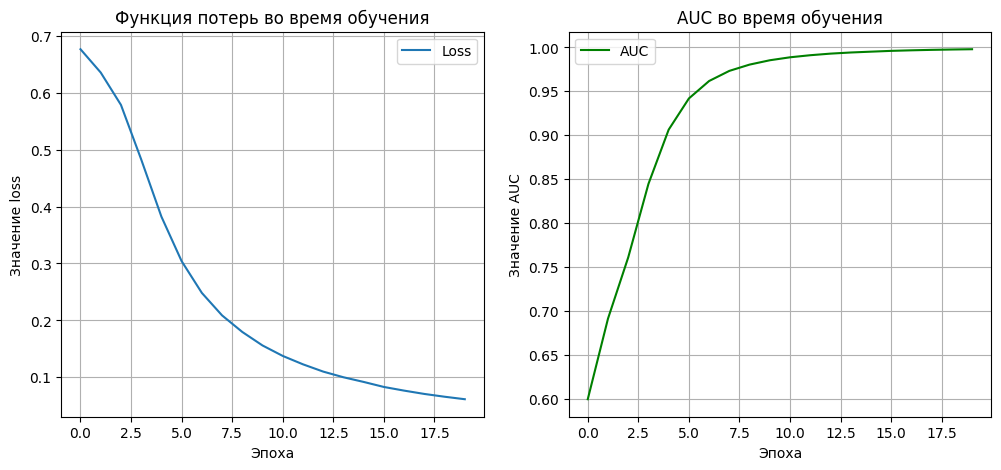

In [111]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Функция потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Значение loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC', color='green')
plt.title('AUC во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Значение AUC')
plt.legend()
plt.grid(True)

plt.show()

In [112]:
user_emb_layer = model.embedding_dict['user']
track_emb_layer = model.embedding_dict['track']

In [113]:
data['track'].unique()

array([14427, 37465, 48906, ..., 33453, 12068, 30916])

In [114]:
user_embeddings = user_emb_layer(torch.tensor(data['user'].unique()).to(device)).detach().cpu().numpy()
track_embeddings = track_emb_layer(torch.tensor(data['track'].unique()).to(device)).detach().cpu().numpy()

In [ ]:
log_dir = "embeddings_logs_difm"
os.makedirs(log_dir, exist_ok=True)

writer = SummaryWriter(log_dir)

writer.add_embedding(torch.tensor(user_embeddings), tag="user_embeddings")
writer.add_embedding(torch.tensor(track_embeddings), tag="track_embeddings")

writer.close()

In [121]:
index = faiss.IndexFlatL2(track_embeddings.shape[1])
index.add(track_embeddings)

_, top_track_indices = index.search(user_embeddings, k=50)


In [122]:
track_ids = data['track'].unique()
user_ids = data['user'].unique()

results = [
    {'user': int(user_ids[i]), 'top_tracks': track_ids[top_track_indices[i]].tolist()}
    for i in tqdm(range(len(user_ids)))
]

100%|██████████| 10000/10000 [00:00<00:00, 199785.84it/s]


In [ ]:
with open("../botify/data/recommendations_difm.json", "w") as rf:
    for d in tqdm(results, total=len(results)):
        recommendation = {
            "user": d['user'],
            "tracks": d['top_tracks']
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████| 10000/10000 [00:00<00:00, 122337.84it/s]
